In [2]:
import numpy as np
from astropy.io import fits
from scipy.io.idl import readsav
import scipy.signal as signal
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import glob


In [3]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


In [163]:
path_to_data = './FAST-N891/'

target_ID = 'N891/'
obs_date = '20210405/'
Beam_ID = 'M10'

filenames=glob.glob(path_to_data+target_ID+obs_date+'/*'+Beam_ID+'_W*.fits')
filenames.sort()
filenames
#after the sort, filesnames would be in the order of xxx_W0001.fits,  xxx_W0002.fits,  xxx_W0003.fits ...

['./FAST-N891/N891/20210405/N891_1_onoff-M10_W_0001.fits']

In [164]:

# Read in the cal data 
tcal_path  = '../OnOff/tcal/'
tcal_hi_w  = 'median_20190115.Tcal-results.HI_w.high.sav'

s = readsav(tcal_path + tcal_hi_w)
freqcal = s.high_w[0]['freq']
Beam_tc = s.high_w[0][Beam_ID+'_TC']        # find the noise diode data for the beam I care
Beam_tc_polave =np.average(Beam_tc,axis=0)  # averaging the two polarization is dangerous. We need to check if the two polar data is consistent
Tcal = Beam_tc_polave


In [165]:
filenames

['./FAST-N891/N891/20210405/N891_1_onoff-M10_W_0001.fits']

In [166]:
hdu = fits.open(filenames[0])

freqbegin = hdu[1].data.field('freq')[0]                 # freq of frist channel
chanbw    = hdu[1].data.field('CHAN_BW')[0]              # Channel width
nchan     = hdu[1].data.field('NCHAN')[0]                # channel number
freq      = freqbegin + (np.arange(nchan)+0)*chanbw    # Freq of all channels

data = hdu[1].data.field('DATA')                    # Data
mjd  = hdu[1].data.field('UTOBS')                   # mjd
start_mjd = mjd[0]

for ind_file in range(len(filenames)-1):
    hdu = fits.open(filenames[ind_file+1])
    # Merging the data 
    data  = np.concatenate([data, hdu[1].data.field('DATA')],axis=0)
    mjd   = np.concatenate([mjd, hdu[1].data.field('UTOBS')],axis=0)



In [167]:
hdu.info()

Filename: ./FAST-N891/N891/20210405/N891_1_onoff-M10_W_0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1  SINGLE DISH    1 BinTableHDU     80   656R x 21C   ['1K', '1K', '16A', '1L', '1D', '24A', '1D', '1D', '1D', '1D', '1D', '1D', '1K', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '262144E']   


In [168]:
data.shape

(656, 65536, 4)

In [169]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
fast_site = EarthLocation(lat= 25.652944444444444 * u.deg, lon=106.85666666666667 *u.deg, height=1110.0288*u.m)  # FAST location.


z = 0.00176                         #target redshift
rasrc = 35.639224                   #target ra
decsrc = 42.349146                  #target dec


freq_line = 1420.405751 / (1 + z)  # in unit of MHz
freq_min = freq_line-2             # in unit of MHz
freq_max = freq_line+2             # in unit of MHz

print(freq_min, freq_line, freq_max)

obs_MJD = np.median(mjd)            # I use median MJD time to derive the velocity of earth during the observation.

sc = SkyCoord(ra=rasrc*u.deg, dec=decsrc*u.deg)

#barycorr = sc.radial_velocity_correction(obstime=Time('2021-01-12'), location=fast_site)
#barycorr.to(u.km/u.s)

heliocorr = sc.radial_velocity_correction('heliocentric', obstime=Time(obs_MJD, format = 'mjd'), location=fast_site)  
Vcorr = heliocorr.to(u.km/u.s).to_value()
print(Vcorr)

## below fomulars are mainly copy from https://www.gb.nrao.edu/GBT/DA/gbtidl/release/user/toolbox/chdoppler.pro
##----- LSR SECTION----------
# THE STANDARD LSR IS DEFINED AS FOLLOWS: THE SUN MOVES AT 20.0 KM/S
# TOWARD RA=18H, DEC=30.0 DEG IN 1900 EPOCH COORDS
# Precessed J2000: 18:03:50.24   30:00:16.8 (18.06395556,30.00466667)
# using PRECESS, this works out to ra=18.063955 dec=30.004661 in J2000 coords.

rasrc_rad  = rasrc * np.pi / 180.
decsrc_rad = decsrc * np.pi / 180.
xxsource = np.array([np.cos(decsrc_rad) * np.cos(rasrc_rad), np.cos(decsrc_rad) * np.sin(rasrc_rad), np.sin(decsrc_rad)])
ralsr_rad  = 18.06395556 * 15. * np.pi / 180.
declsr_rad = 30.00466667 * np.pi / 180.
vvlsr = 20 * np.array([np.cos(declsr_rad)* np.cos(ralsr_rad), np.cos(declsr_rad)* np.sin(ralsr_rad), np.sin(declsr_rad)])

pvlsr = (vvlsr*xxsource).sum()
vvvlst = -Vcorr-pvlsr

print(vvvlst, Vcorr, pvlsr)

c        =  2.99792458e5  # km/s
velo     =  c*(freq_line-freq)/freq_line 
velo_c   =  c*(1420.405751-freq)/1420.405751 
vlsr     =  velo-vvvlst   # Velocity in LSR
vlsr_c   =  velo_c-vvvlst   # Velocity in LSR



1415.9102289969653 1417.9102289969653 1419.9102289969653
-14.663891017432261
15.209660655132033 -14.663891017432261 -0.545769637699772


In [170]:
data.shape

(656, 65536, 4)

In [171]:
freq

array([1000.00357628, 1000.01120567, 1000.01883507, ..., 1499.9806881 ,
       1499.98831749, 1499.99594688])

In [172]:
# The ON-OFF mode is in fact a cycle of ON the target, shift from ON to OFF, OFF the target, shift from OFF to ON, ON the target

# set the on_time for one ON-OFF cycle:
on_time = 5 #  min

# if ON- OFF distance is larger then 30 arcmin. It takes 1min to change the pointing from ON to OFF the target.
# if ON - OFF distance is lower then 30 arcmin. It takes 0.5min to change the pointing from ON to OFF the target.
int_time = 1. #  min

min_to_MJD    = 1./60./24.  # mjd value for 1 minute
start_mjd = mjd[0]

# I build a long time list in case there are lots of ON-OFF.
cycles_mjd = [\
start_mjd +  0 * on_time * min_to_MJD + 0 * int_time * min_to_MJD , start_mjd +  1 * on_time * min_to_MJD + 0 * int_time * min_to_MJD , # 1st on the target 
start_mjd +  1 * on_time * min_to_MJD + 1 * int_time * min_to_MJD , start_mjd +  2 * on_time * min_to_MJD + 1 * int_time * min_to_MJD , # 1st off the target 
start_mjd +  2 * on_time * min_to_MJD + 2 * int_time * min_to_MJD , start_mjd +  3 * on_time * min_to_MJD + 2 * int_time * min_to_MJD , # 2nd on the target 
start_mjd +  3 * on_time * min_to_MJD + 3 * int_time * min_to_MJD , start_mjd +  4 * on_time * min_to_MJD + 3 * int_time * min_to_MJD , # 2nd off the target 
start_mjd +  4 * on_time * min_to_MJD + 4 * int_time * min_to_MJD , start_mjd +  5 * on_time * min_to_MJD + 4 * int_time * min_to_MJD , # 3rd on the target 
start_mjd +  5 * on_time * min_to_MJD + 5 * int_time * min_to_MJD , start_mjd +  6 * on_time * min_to_MJD + 5 * int_time * min_to_MJD , # 3rd off the target 
start_mjd +  6 * on_time * min_to_MJD + 6 * int_time * min_to_MJD , start_mjd +  7 * on_time * min_to_MJD + 6 * int_time * min_to_MJD , # 4th on the target 
start_mjd +  7 * on_time * min_to_MJD + 7 * int_time * min_to_MJD , start_mjd +  8 * on_time * min_to_MJD + 7 * int_time * min_to_MJD , # 4th off the target 
start_mjd +  8 * on_time * min_to_MJD + 8 * int_time * min_to_MJD , start_mjd +  9 * on_time * min_to_MJD + 8 * int_time * min_to_MJD , # 5th on the target 
start_mjd +  9 * on_time * min_to_MJD + 9 * int_time * min_to_MJD , start_mjd +  10 * on_time * min_to_MJD + 9 * int_time * min_to_MJD , # 5th off the target 
start_mjd +  10 * on_time * min_to_MJD + 10 * int_time * min_to_MJD , start_mjd +  11 * on_time * min_to_MJD + 10 * int_time * min_to_MJD , # 6th on the target 
start_mjd +  11 * on_time * min_to_MJD + 11 * int_time * min_to_MJD , start_mjd +  12 * on_time * min_to_MJD + 11 * int_time * min_to_MJD ] # 6th off the target 

cycles_mjd

[59309.260416666664,
 59309.26388888888,
 59309.26458333333,
 59309.268055555556,
 59309.268749999996,
 59309.272222222215,
 59309.27291666666,
 59309.27638888889,
 59309.277083333334,
 59309.28055555555,
 59309.28124999999,
 59309.28472222222,
 59309.285416666666,
 59309.288888888885,
 59309.28958333333,
 59309.29305555556,
 59309.293750000004,
 59309.29722222222,
 59309.29791666666,
 59309.30138888888,
 59309.30208333333,
 59309.305555555555,
 59309.30625,
 59309.30972222222]

In [173]:
# select the ON and OFF index during the ON-OFF cycle.

cycle1_on_mjd_idx  =   ((mjd >= cycles_mjd[0]) & (mjd <= cycles_mjd[1]))
cycle1_off_mjd_idx =   ((mjd >= cycles_mjd[2]) & (mjd <= cycles_mjd[3]))

cycle2_on_mjd_idx  =   ((mjd >= cycles_mjd[4]) & (mjd <= cycles_mjd[5]))
cycle2_off_mjd_idx =   ((mjd >= cycles_mjd[6]) & (mjd <= cycles_mjd[7]))

cycle3_on_mjd_idx  =   ((mjd >= cycles_mjd[8]) & (mjd <= cycles_mjd[9]))
cycle3_off_mjd_idx =   ((mjd >= cycles_mjd[10]) & (mjd <= cycles_mjd[11]))

cycle4_on_mjd_idx  =   ((mjd >= cycles_mjd[12]) & (mjd <= cycles_mjd[13]))
cycle4_off_mjd_idx =   ((mjd >= cycles_mjd[14]) & (mjd <= cycles_mjd[15]))

cycle5_on_mjd_idx  =   ((mjd >= cycles_mjd[16]) & (mjd <= cycles_mjd[17]))
cycle5_off_mjd_idx =   ((mjd >= cycles_mjd[18]) & (mjd <= cycles_mjd[19]))


In [174]:
data[cycle1_on_mjd_idx,:,0:2]

array([[[8.23621786e+14, 4.38351476e+14],
        [1.96322755e+11, 1.87182629e+11],
        [1.73958791e+11, 1.67810466e+11],
        ...,
        [1.26578406e+12, 1.11582459e+12],
        [1.31020829e+12, 1.12099236e+12],
        [1.45693501e+12, 1.27628123e+12]],

       [[8.90270418e+14, 4.49565166e+14],
        [1.44607756e+11, 1.42119043e+11],
        [1.29452474e+11, 1.22869719e+11],
        ...,
        [8.46800552e+11, 7.60989024e+11],
        [8.57963561e+11, 7.89394096e+11],
        [9.74340358e+11, 9.25316219e+11]],

       [[8.56605726e+14, 4.03976705e+14],
        [1.95233104e+11, 1.88956508e+11],
        [1.81147320e+11, 1.73380682e+11],
        ...,
        [1.25972919e+12, 1.14390034e+12],
        [1.27779524e+12, 1.14655520e+12],
        [1.41832487e+12, 1.29204355e+12]],

       ...,

       [[8.90404770e+14, 4.06386148e+14],
        [1.97941707e+11, 1.91481446e+11],
        [1.75782035e+11, 1.75800058e+11],
        ...,
        [1.32514002e+12, 1.15636948e+12],
     

In [175]:
#To split the index when the noise diode on and off
power1_on  = np.average(data[cycle1_on_mjd_idx,:,0:2],axis=2)    # averaging the two polarization is dangerous. We need to check if the two polar data is consistent
power1_off = np.average(data[cycle1_off_mjd_idx,:,0:2],axis=2)   # averaging the two polarization is dangerous. We need to check if the two polar data is consistent

#power2_on  = np.average(data[cycle2_on_mjd_idx,:,0:2],axis=2)
#power2_off = np.average(data[cycle2_off_mjd_idx,:,0:2],axis=2)
#
#power3_on  = np.average(data[cycle3_on_mjd_idx,:,0:2],axis=2)
#power3_off = np.average(data[cycle3_off_mjd_idx,:,0:2],axis=2)
#
#power4_on  = np.average(data[cycle4_on_mjd_idx,:,0:2],axis=2)
#power4_off = np.average(data[cycle4_off_mjd_idx,:,0:2],axis=2)
#
#power5_on  = np.average(data[cycle5_on_mjd_idx,:,0:2],axis=2)
#power5_off = np.average(data[cycle5_off_mjd_idx,:,0:2],axis=2)
#


In [176]:
power1_on.shape, cycle1_on_mjd_idx.shape #, power2_on.shape, cycle2_on_mjd_idx.shape

((299, 65536), (656,))

In [177]:
np.arange(0,298,2)

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258,
       260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284,
       286, 288, 290, 292, 294, 296])

In [178]:
np.arange(1,298,2)

array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
       157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181,
       183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207,
       209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233,
       235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259,
       261, 263, 265, 267, 269, 271, 273, 275, 277, 279, 281, 283, 285,
       287, 289, 291, 293, 295, 297])

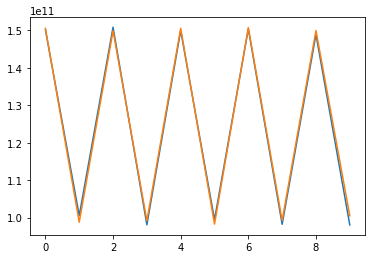

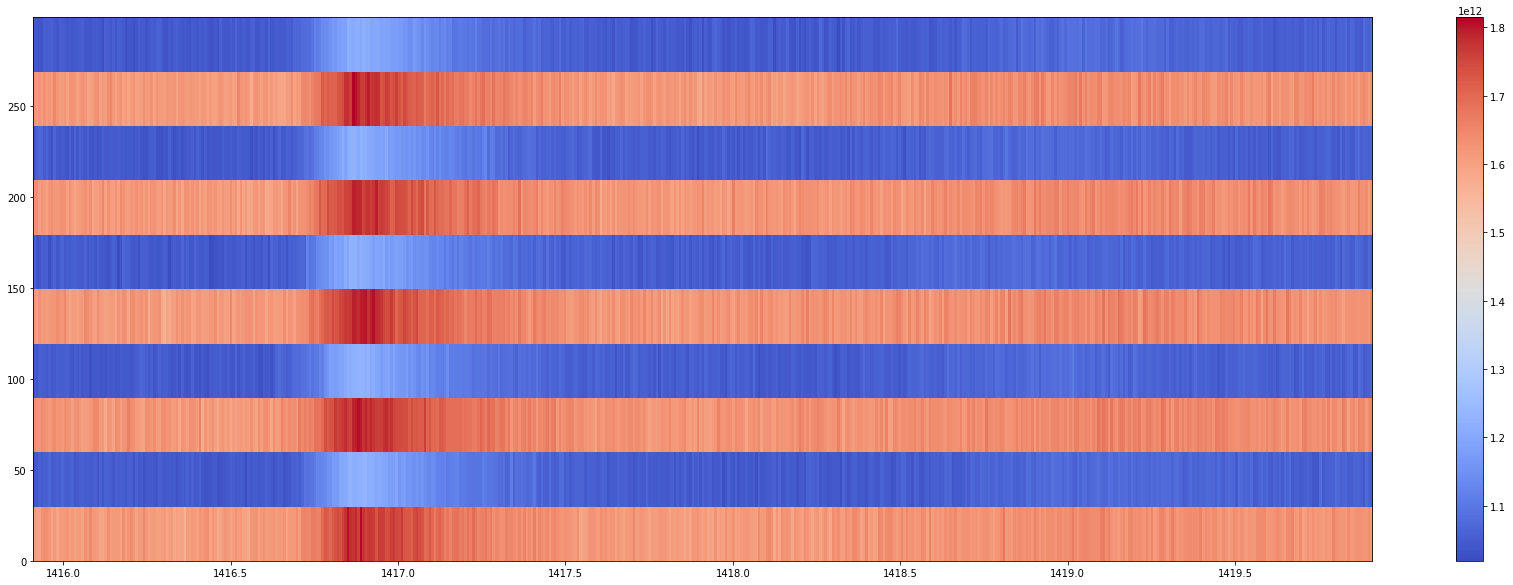

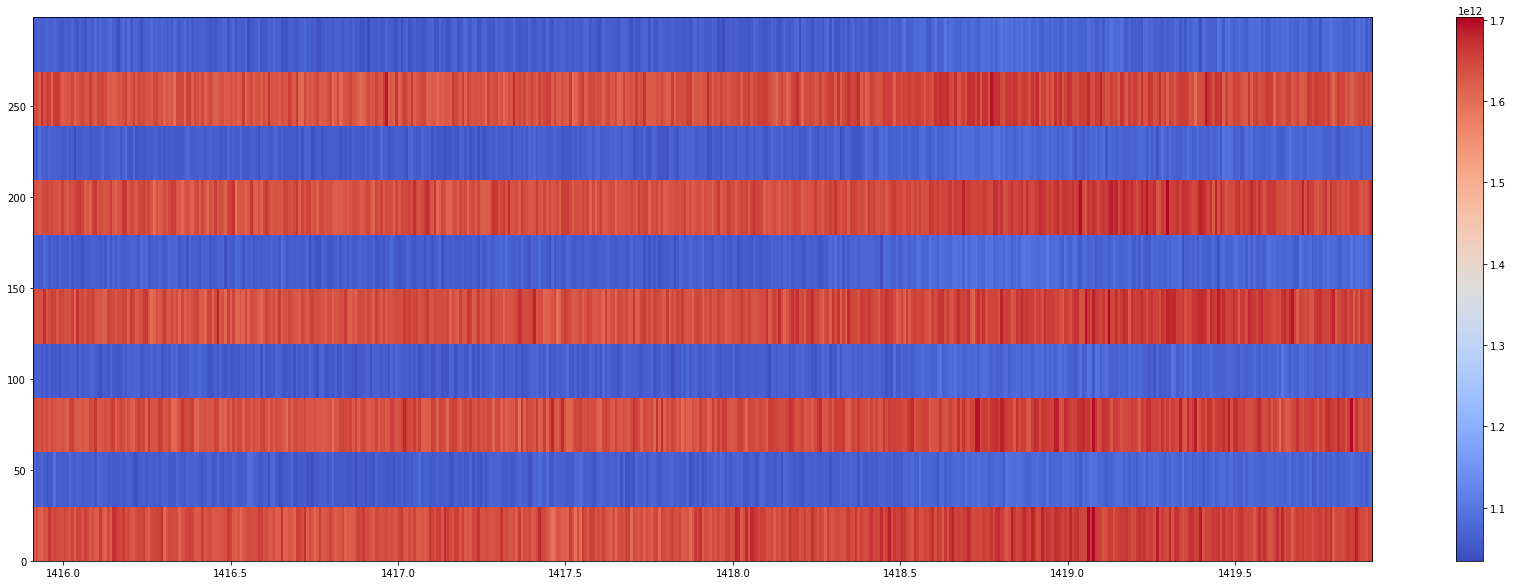

In [179]:

# Sometimes the noise on and off is shifted a little bit because the extraction time is not exactly one second, but 1006632960 nano second = 1.006632960 second.
# So I plot the first 10 spectra to check if the noise is on and off regularly.

plt.plot(power1_on[0:10,40])
plt.plot(power1_off[0:10,40])

if power1_on[0,40] > power1_on[1,40]:
    power1_on_calon  = power1_on[np.arange(0,298,2),:]
    power1_on_caloff = power1_on[np.arange(1,298,2),:]
else:
    power1_on_calon  = power1_on[np.arange(1,298,2),:]
    power1_on_caloff = power1_on[np.arange(0,298,2),:]

if power1_off[0,40] > power1_off[1,40]:
    power1_off_calon  = power1_off[np.arange(0,298,2),:]
    power1_off_caloff = power1_off[np.arange(1,298,2),:]
else:
    power1_off_calon  = power1_off[np.arange(1,298,2),:]
    power1_off_caloff = power1_off[np.arange(0,298,2),:]


power1_on_calon.shape, power1_on_caloff.shape 
power1_on_calres = power1_on_calon-power1_on_caloff 
power1_off_calres = power1_off_calon-power1_off_caloff 

#here we need to check if the noise on-off-on-off works well when we split the data. Sometimes there are on-on-off-on-off ... cycles

plt.figure(figsize=(30,10))
plt.imshow(power1_on[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power1_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power1_off[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power1_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

# For each frequency:
T_to_P_freq = Tcal / np.average(power1_on_calres,axis=0)

Ta1_on = power1_on_calon - power1_on_calon
for i, iTal_on in enumerate(Ta1_on):
    
    a   = power1_on_calon[i,:] * T_to_P_freq 
    c   = power1_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta1_on[i,:]  =  w1 * (power1_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power1_on_caloff[i,:] * T_to_P_freq)
    
    
Ta1_off = power1_off_calon - power1_off_calon
for i, iTal_off in enumerate(Ta1_off):
    
    a   = power1_off_calon[i,:] * T_to_P_freq 
    c   = power1_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta1_off[i,:]  =  w1 * (power1_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power1_off_caloff[i,:] * T_to_P_freq)


# Sometimes there were several ON-OFF with noise diode on and off, here are example for five cycles
# change these cells from Markdown into Code

# The np.arrange(0,298,2) and np.arange(1,298,2) for 10 min ON and 10 min OFF
# The np.arrange(0,596,2) and np.arange(1,596,2) for 10 min ON and 10 min OFF

plt.plot(power2_on[0:10,40])
plt.plot(power2_off[0:10,40])


if power2_on[0,40] > power2_on[1,40]:
    power2_on_calon  = power2_on[np.arange(0,596,2),:]
    power2_on_caloff = power2_on[np.arange(1,596,2),:]
else:
    power2_on_calon  = power2_on[np.arange(1,596,2),:]
    power2_on_caloff = power2_on[np.arange(0,596,2),:]


if power2_off[0,40] > power2_off[1,40]:
    power2_off_calon  = power2_off[np.arange(0,596,2),:]
    power2_off_caloff = power2_off[np.arange(1,596,2),:]
else:
    power2_off_calon  = power2_off[np.arange(1,596,2),:]
    power2_off_caloff = power2_off[np.arange(0,596,2),:]


power2_on_calon.shape, power2_on_caloff.shape 
power2_on_calres = power2_on_calon-power2_on_caloff 
power2_off_calres = power2_off_calon-power2_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power2_on[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power2_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power2_off[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power2_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power2_on_calres,axis=0)


Ta2_on = power2_on_calon - power2_on_calon
for i, iTal_on in enumerate(Ta2_on):
    
    a   = power2_on_calon[i,:] * T_to_P_freq 
    c   = power2_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta2_on[i,:]  =  w1 * (power2_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power2_on_caloff[i,:] * T_to_P_freq)
    
    
Ta2_off = power2_off_calon - power2_off_calon
for i, iTal_off in enumerate(Ta2_off):
    
    a   = power2_off_calon[i,:] * T_to_P_freq 
    c   = power2_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta2_off[i,:]  =  w1 * (power2_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power2_off_caloff[i,:] * T_to_P_freq)


plt.plot(power3_on[0:100,40])
plt.plot(power3_off[0:100,40])

if power3_on[0,40] > power3_on[1,40]:
    power3_on_calon  = power3_on[np.arange(0,596,2),:]
    power3_on_caloff = power3_on[np.arange(1,596,2),:]
else:
    power3_on_calon  = power3_on[np.arange(1,596,2),:]
    power3_on_caloff = power3_on[np.arange(0,596,2),:]

if power3_off[0,40] > power3_off[1,40]:
    power3_off_calon  = power3_off[np.arange(0,596,2),:]
    power3_off_caloff = power3_off[np.arange(1,596,2),:]
else:
    power3_off_calon  = power3_off[np.arange(1,596,2),:]
    power3_off_caloff = power3_off[np.arange(0,595,2),:]

power3_on_calon.shape, power3_on_caloff.shape 
power3_on_calres = power3_on_calon-power3_on_caloff 
power3_off_calres = power3_off_calon-power3_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power3_on[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power3_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power3_off[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power3_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power3_on_calres,axis=0)


Ta3_on = power3_on_calon - power3_on_calon
for i, iTal_on in enumerate(Ta3_on):
    
    a   = power3_on_calon[i,:] * T_to_P_freq 
    c   = power3_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta3_on[i,:]  =  w1 * (power3_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power3_on_caloff[i,:] * T_to_P_freq)
    
    
Ta3_off = power3_off_calon - power3_off_calon
for i, iTal_off in enumerate(Ta3_off):
    
    a   = power3_off_calon[i,:] * T_to_P_freq 
    c   = power3_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta3_off[i,:]  =  w1 * (power3_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power3_off_caloff[i,:] * T_to_P_freq)


plt.plot(power4_on[0:10,40])
plt.plot(power4_off[0:10,40])

if power4_on[0,40] > power4_on[1,40]:
    power4_on_calon  = power4_on[np.arange(0,596,2),:]
    power4_on_caloff = power4_on[np.arange(1,596,2),:]
else:
    power4_on_calon  = power4_on[np.arange(1,596,2),:]
    power4_on_caloff = power4_on[np.arange(0,596,2),:]



if power4_off[0,40] > power4_off[1,40]:
    power4_off_calon  = power4_off[np.arange(0,596,2),:]
    power4_off_caloff = power4_off[np.arange(1,596,2),:]
else:
    power4_off_calon  = power4_off[np.arange(1,596,2),:]
    power4_off_caloff = power4_off[np.arange(0,596,2),:]


power4_on_calon.shape, power4_on_caloff.shape 
power4_on_calres = power4_on_calon-power4_on_caloff 
power4_off_calres = power4_off_calon-power4_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power4_on[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power4_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power4_off[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power4_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power4_on_calres,axis=0)


Ta4_on = power4_on_calon - power4_on_calon
for i, iTal_on in enumerate(Ta4_on):
    
    a   = power4_on_calon[i,:] * T_to_P_freq 
    c   = power4_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta4_on[i,:]  =  w1 * (power4_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power4_on_caloff[i,:] * T_to_P_freq)
    
    
Ta4_off = power4_off_calon - power4_off_calon
for i, iTal_off in enumerate(Ta4_off):
    
    a   = power4_off_calon[i,:] * T_to_P_freq 
    c   = power4_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta4_off[i,:]  =  w1 * (power4_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power4_off_caloff[i,:] * T_to_P_freq)


plt.plot(power5_on[0:10,40])
plt.plot(power5_off[0:10,40])

if power5_on[0,40] > power5_on[1,40]:
    power5_on_calon  = power5_on[np.arange(0,596,2),:]
    power5_on_caloff = power5_on[np.arange(1,596,2),:]
else:
    power5_on_calon  = power5_on[np.arange(1,596,2),:]
    power5_on_caloff = power5_on[np.arange(0,596,2),:]



if power5_off[0,40] > power5_off[1,40]:
    power5_off_calon  = power5_off[np.arange(0,596,2),:]
    power5_off_caloff = power5_off[np.arange(1,596,2),:]
else:
    power5_off_calon  = power5_off[np.arange(1,596,2),:]
    power5_off_caloff = power5_off[np.arange(0,596,2),:]


power5_on_calon.shape, power5_on_caloff.shape 
power5_on_calres = power5_on_calon-power5_on_caloff 
power5_off_calres = power5_off_calon-power5_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power5_on[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power5_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power5_off[0:10,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power5_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power5_on_calres,axis=0)


Ta5_on = power5_on_calon - power5_on_calon
for i, iTal_on in enumerate(Ta5_on):
    
    a   = power5_on_calon[i,:] * T_to_P_freq 
    c   = power5_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta5_on[i,:]  =  w1 * (power5_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power5_on_caloff[i,:] * T_to_P_freq)
    
    
Ta5_off = power5_off_calon - power5_off_calon
for i, iTal_off in enumerate(Ta5_off):
    
    a   = power5_off_calon[i,:] * T_to_P_freq 
    c   = power5_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta5_off[i,:]  =  w1 * (power5_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power5_off_caloff[i,:] * T_to_P_freq)


# virtical stack the five ON-OFF cycles:
Ta_on = np.vstack((Ta1_on,Ta2_on,Ta3_on,Ta4_on,Ta5_on))
Ta_off = np.vstack((Ta1_off,Ta2_off,Ta3_off,Ta4_off,Ta5_off))



In [180]:
Ta_on = np.vstack((Ta1_on))
Ta_off = np.vstack((Ta1_off))

In [181]:
Ta_on.shape, Ta_off.shape

((149, 65536), (149, 65536))

In [182]:
np.average(Ta_on, axis=0).shape

(65536,)

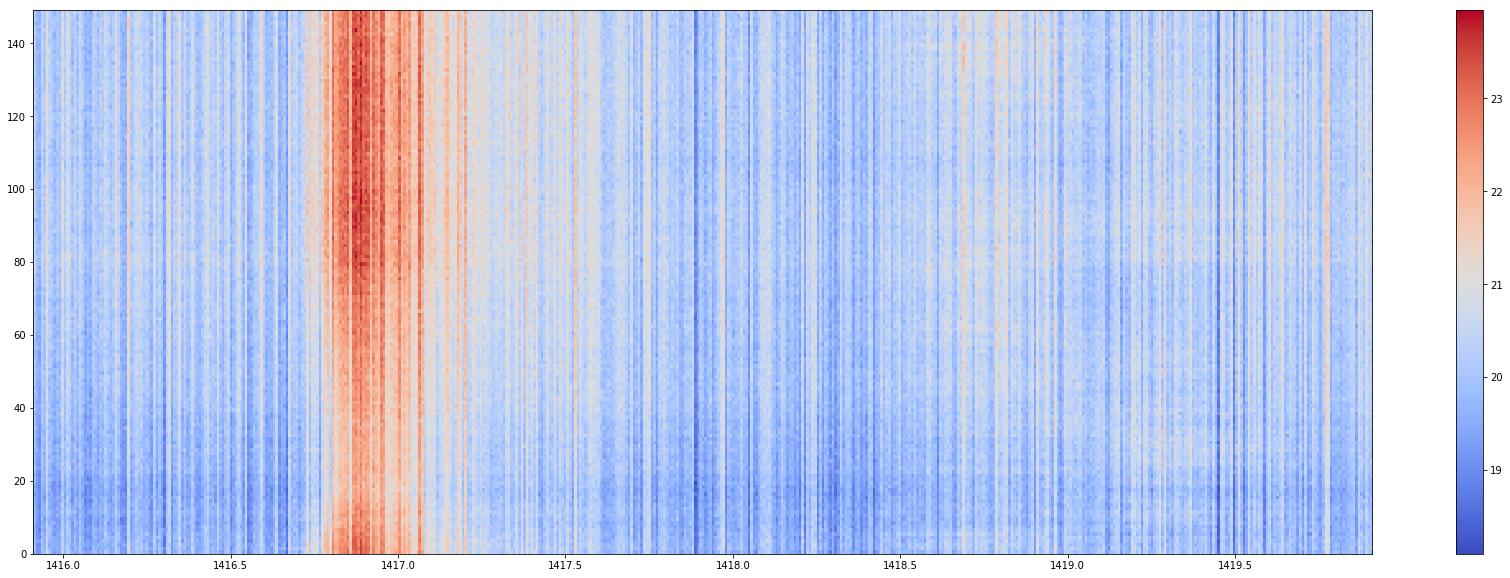

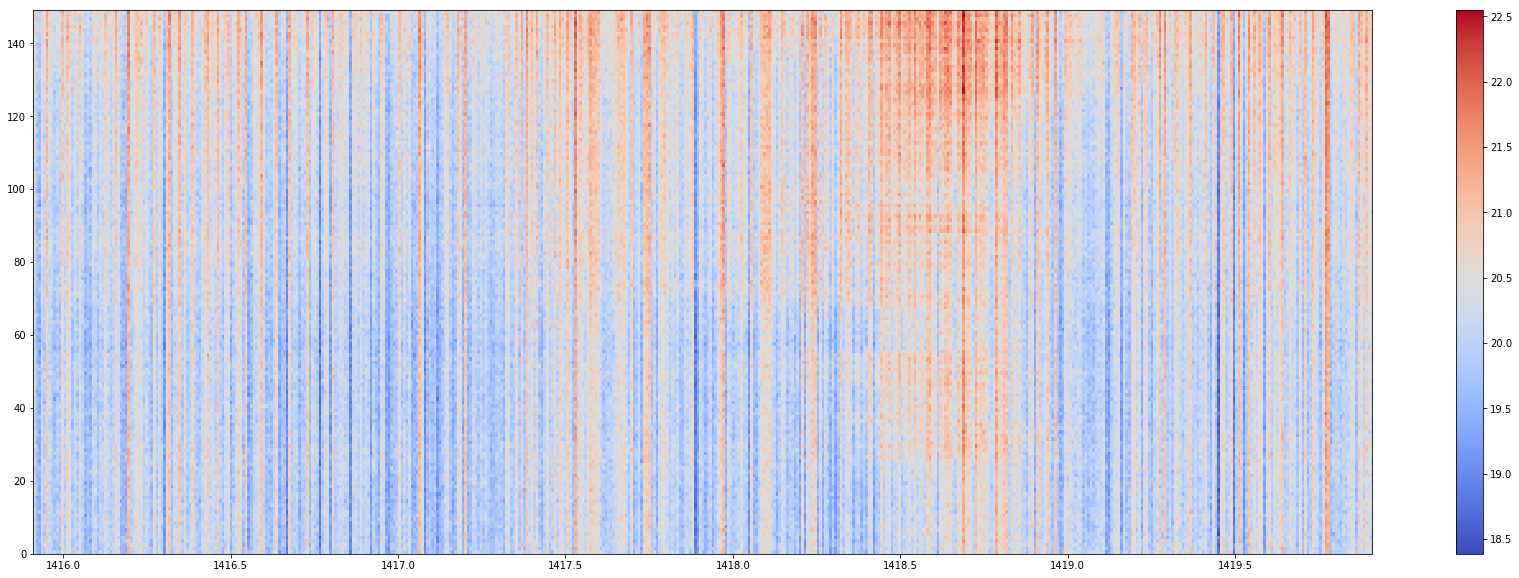

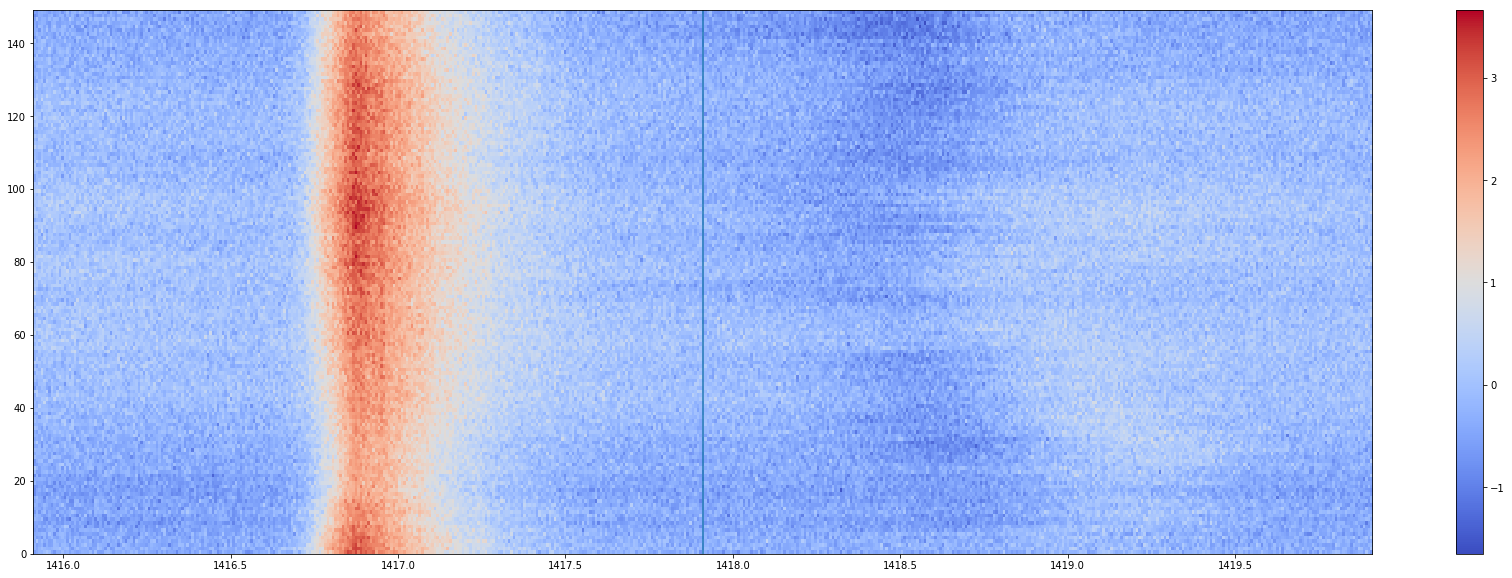

In [183]:
plt.figure(figsize=(30,10))
plt.imshow(Ta_on[:,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,Ta_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(Ta_off[:,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,Ta_off[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

Ta_target = Ta_on - Ta_off

plt.figure(figsize=(30,10))
plt.imshow(Ta_target[:,((freq > freq_min) & (freq < freq_max))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,Ta_target[:,0].size), 
          cmap='coolwarm')
plt.plot([freq_line, freq_line], [0,Ta_target[:,0].size])
plt.colorbar()

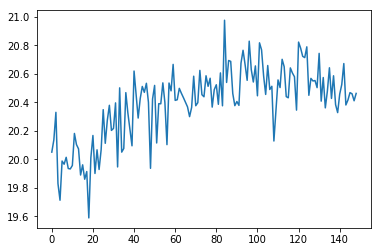

In [191]:
#From the above map, I can see the flux is quite bright.
# Then I need at least check the Ta with time.

plt.plot(Ta_on[:,55000])

#Sometimes there are some sparks, and I need to deside if need to sigma clip some spectra.

(1415.9102289969653, 1419.9102289969653)

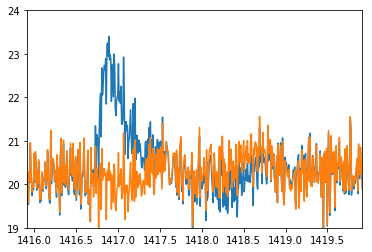

In [193]:
#
plt.plot(freq, np.median(Ta_on, axis=0))
plt.plot(freq, np.median(Ta_off, axis=0))

plt.plot([freq_line, freq_line], [0,1])
plt.ylim(19,24)
plt.xlim(freq_min,freq_max)


(1415.9102289969653, 1419.9102289969653)

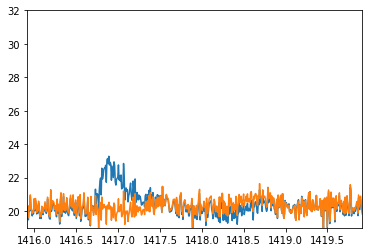

In [194]:
plt.plot(freq, np.average(Ta_on, axis=0))
plt.plot(freq, np.average(Ta_off, axis=0))

plt.plot([freq_line, freq_line], [0,1])
plt.ylim(19,32)
plt.xlim(freq_min,freq_max)


(1415.9102289969653, 1419.9102289969653)

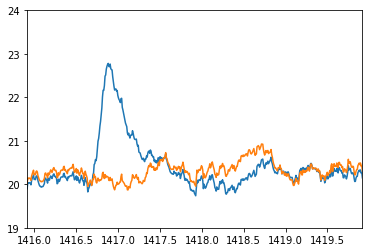

In [197]:
plt.plot(freq, smooth(np.average(Ta_on, axis=0),10))
plt.plot(freq, smooth(np.average(Ta_off, axis=0),10))

plt.plot([freq_line, freq_line], [0,1])
plt.ylim(19,24)
plt.xlim(freq_min,freq_max)


(1415.9102289969653, 1419.9102289969653)

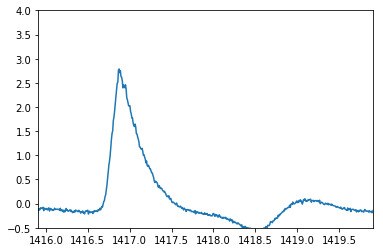

In [199]:
plt.plot(freq, np.average(Ta_target, axis=0))
plt.plot([freq_line, freq_line], [6,7])
plt.ylim(-0.5,4)
plt.xlim(freq_min,freq_max)

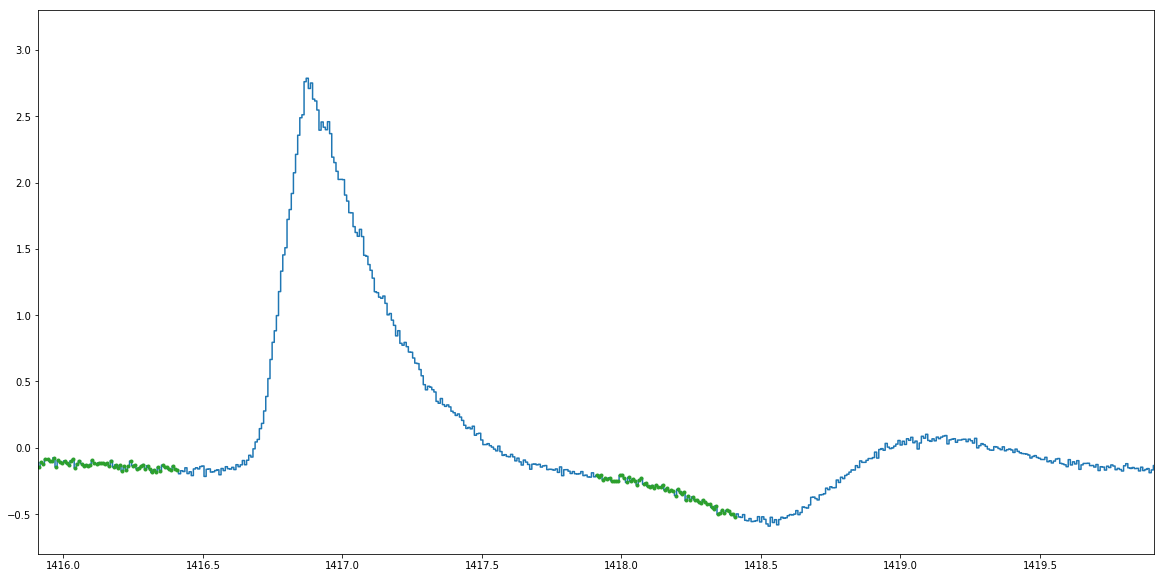

In [207]:
# check the base line fitting range:
# The ind_baseline is used for the baseline fitting. Sometimes it is not easy to deside where is the proper baseline range.
# If the S/N is bad, it is easy to *creat* signal by subtracting a lower baseline, which is dangerous. 

plt.figure(figsize=(20,10))
Ta_target_avg = np.average(Ta_target, axis=0)
ind_baseline  =  ((freq >= freq_min) & (freq <= freq_line-1.5)) | ((freq >= freq_line) & (freq <= freq_max-1.5))

plt.plot(freq, Ta_target_avg, drawstyle='steps-mid')
plt.plot([freq_line, freq_line], [5,6])
plt.ylim(-0.8,3.3)
plt.xlim(freq_min,freq_max)
plt.plot(freq[ind_baseline], Ta_target_avg[ind_baseline], '.')


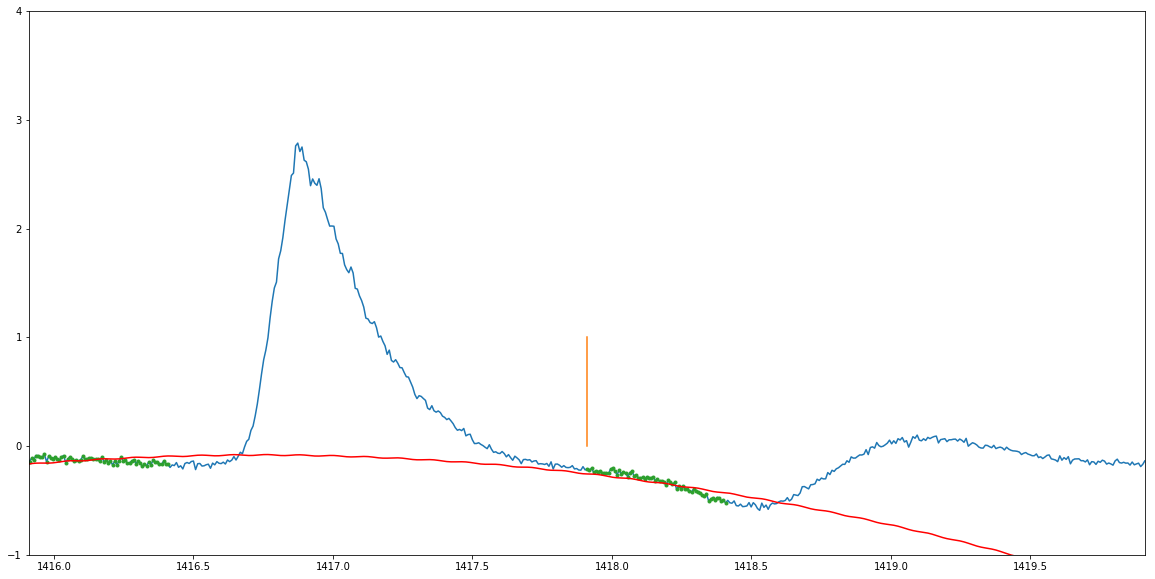

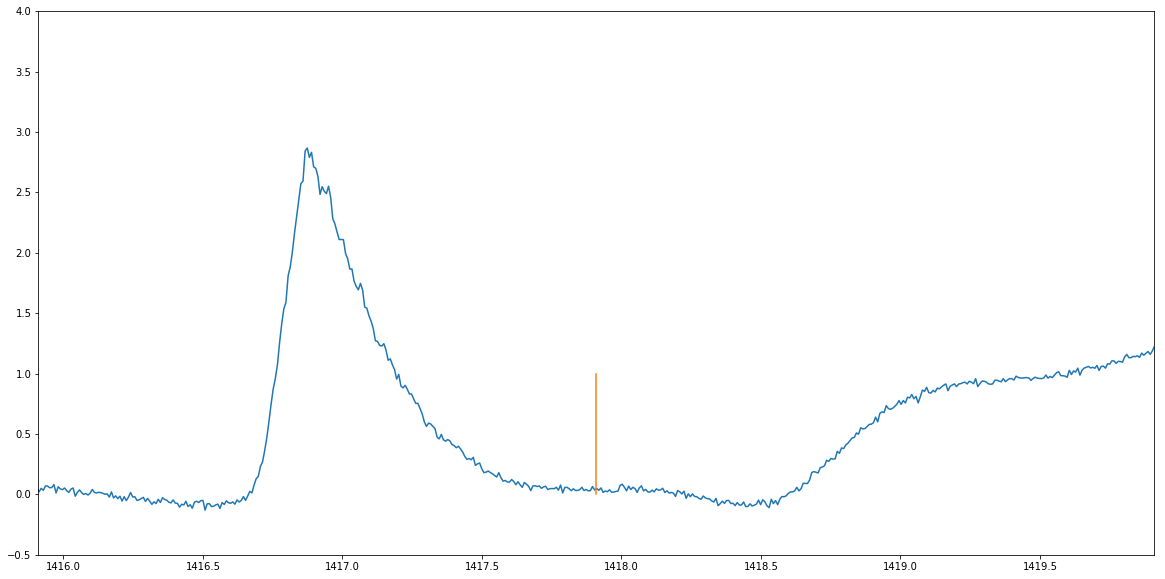

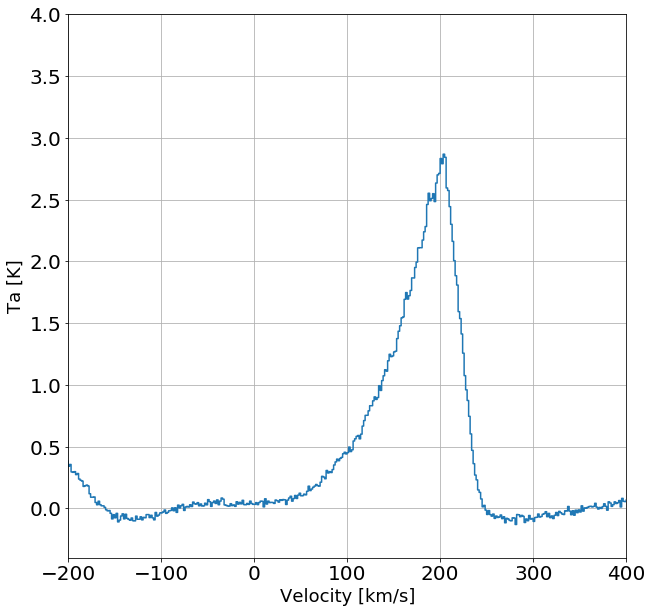

In [209]:
def sinfunc(x,a,b,c,w,p,a1,a2,a3,a4,a5):
    return  a+b*x+a1*x**2+a2*x**3+a3*x**4+a4*x**5+a5*x**6+c*np.sin(2*np.pi/w*x+p)

Ta_target_avg = np.average(Ta_target, axis=0)

ind_baseline  =  ((freq >= freq_min) & (freq <= freq_line-1.5)) | ((freq >= freq_line) & (freq <= freq_max-1.5))

plt.figure(figsize=(20,10))

plt.plot(freq, Ta_target_avg)
plt.plot([freq_line, freq_line], [0,1])
plt.ylim(-1,4)
plt.xlim(freq_min,freq_max)
plt.plot(freq[ind_baseline], Ta_target_avg[ind_baseline], '.')

popt,pcov = curve_fit(sinfunc,freq[ind_baseline], Ta_target_avg[ind_baseline],p0=[0.2,0.0,0.1,0.08,0.0,0.0,0.0,0.0,0.0,0.0])

plt.plot(freq,sinfunc(freq,*popt),color='r')

Ta_target_avg_sub = Ta_target_avg-sinfunc(freq,*popt)

plt.figure(figsize=(20,10))
plt.plot(freq, Ta_target_avg_sub)
plt.plot([freq_line, freq_line], [0,1])
plt.ylim(-0.5,4)
plt.xlim(freq_min,freq_max)

plt.figure(figsize=(10,10))
plt.plot(vlsr, Ta_target_avg_sub, drawstyle='steps-mid')
plt.ylim(-0.4,4)
plt.xlim(-200,400)
plt.xlabel('Velocity [km/s]',fontsize=18)
plt.ylabel('Ta [K]',fontsize=18)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid()

#plt.figure(figsize=(10,10))
#plt.plot(vlsr, Ta_target_avg_sub/15.)
#plt.ylim(-0.1,0.2)
#plt.xlim(-100,100)
